# Generate animations of geostrophic velocities, T, S and sea level height properties.

Produced by Chris Traill 

christopher.traill@utas.edu.au

https://github.com/cdtraill


Date last updated: 18/11/2025

This markdown utilises two products from the Copernicus Marine Service catalogue. 

The ARMOR 3D product (MULTIOBS_GLO_PHY_TSUV_3D_MYNRT_015_012) contains 4D gridded reanalysis time series of temperature, salinity, mixed layer depth (de Boyer-Montegut et al 2004 variable criteria), geostrophic velocitys and geopotential height. https://data.marine.copernicus.eu/product/MULTIOBS_GLO_PHY_TSUV_3D_MYNRT_015_012/description

The Global Ocean Gridded L4 Sea Surface Heights And Derived Variables Nrt (SEALEVEL_GLO_PHY_L4_MY_008_047) contains sea height data with respect to geoid (ADT) and sea level (SLA), including error and sea ice masks. https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/description

Data is downloaded using the Copernicus Marine Service subset tools (see complementary notebook with details on accessing catalogue products including metadata and subset details). 

In [4]:
# Load dependencies
import os
import sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator

In [5]:
## Check environment and Set required path to data file. 
conda_env = os.environ.get("CONDA_DEFAULT_ENV")
print(f"Current conda environment: {conda_env}")
print("Python executable:", sys.executable)
print("Python version:", sys.version)

path = '/Users/christoph/OneDrive - University of Tasmania/Research/PhD Project/Theme 3 Model Obs/'
os.chdir(path)
print(f"Current working directory: {os.getcwd()}")

Current conda environment: base
Python executable: /Users/christoph/opt/anaconda3/envs/Analysis/bin/python
Python version: 3.10.18 (main, Jun  5 2025, 08:13:51) [Clang 14.0.6 ]
Current working directory: /Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs


## Load ARMOR 3D dataset

In [6]:
tsmld_nc = xr.open_dataset('CMS ARMOR 3D TSMLD Product/ARMOR_3D_L4_TSMLD_Weekly_NRT_114E_116E_65S_35S_0_5000m.nc')

In [7]:
## OPTIONAL Subset to desired region by slicing lat and lon
tsmld_nc_subset = tsmld_nc.sel(longitude = slice(114.875, 114.875), time=slice('1998-01-01', None))
tsmld_nc.close()

## GEBCO data

Download GEBCO elevation data: https://download.gebco.net/

Information on the GEBCO 2025 grid: The GEBCO_2025 Grid is a global terrain model for ocean and land, providing elevation data, in meters, on a 15 arc-second interval grid. https://www.gebco.net/data-products-gridded-bathymetry-data/gebco2025-grid

This is used to provide bathymetry infill on transect plotting (mean elevation over 0.2 degree longitudinal band)

In [8]:
# Load GEBCO NetCDF file
gebco = xr.open_dataset("CMS ARMOR 3D TSMLD Product/gebco_2025_n-35.0_s-65.0_w114.0_e116.0.nc")  # adjust path as needed

# GEBCO variables are often named 'elevation'
# Positive = land elevation, Negative = ocean depth
bath = gebco['elevation']

# Select the fixed longitude
lon0 = 115  # your transect lon
lon_band = 0.1  # degrees either side

lat_min, lat_max = -65, -35

# Slice GEBCO
transect = bath.sel(
    lon=slice(lon0 - lon_band, lon0 + lon_band),
    lat=slice(lat_min, lat_max)
)

transect_mean = transect.mean(dim='lon')

# Flip sign so ocean depth is positive downward
ocean_depth = -transect_mean
ocean_depth_lat = ocean_depth.lat # Explicit lat values
ocean_depth = ocean_depth.values # Explicit bathymetry values

## Plot panels of each ARMOR 3D variable overlaid with MLD

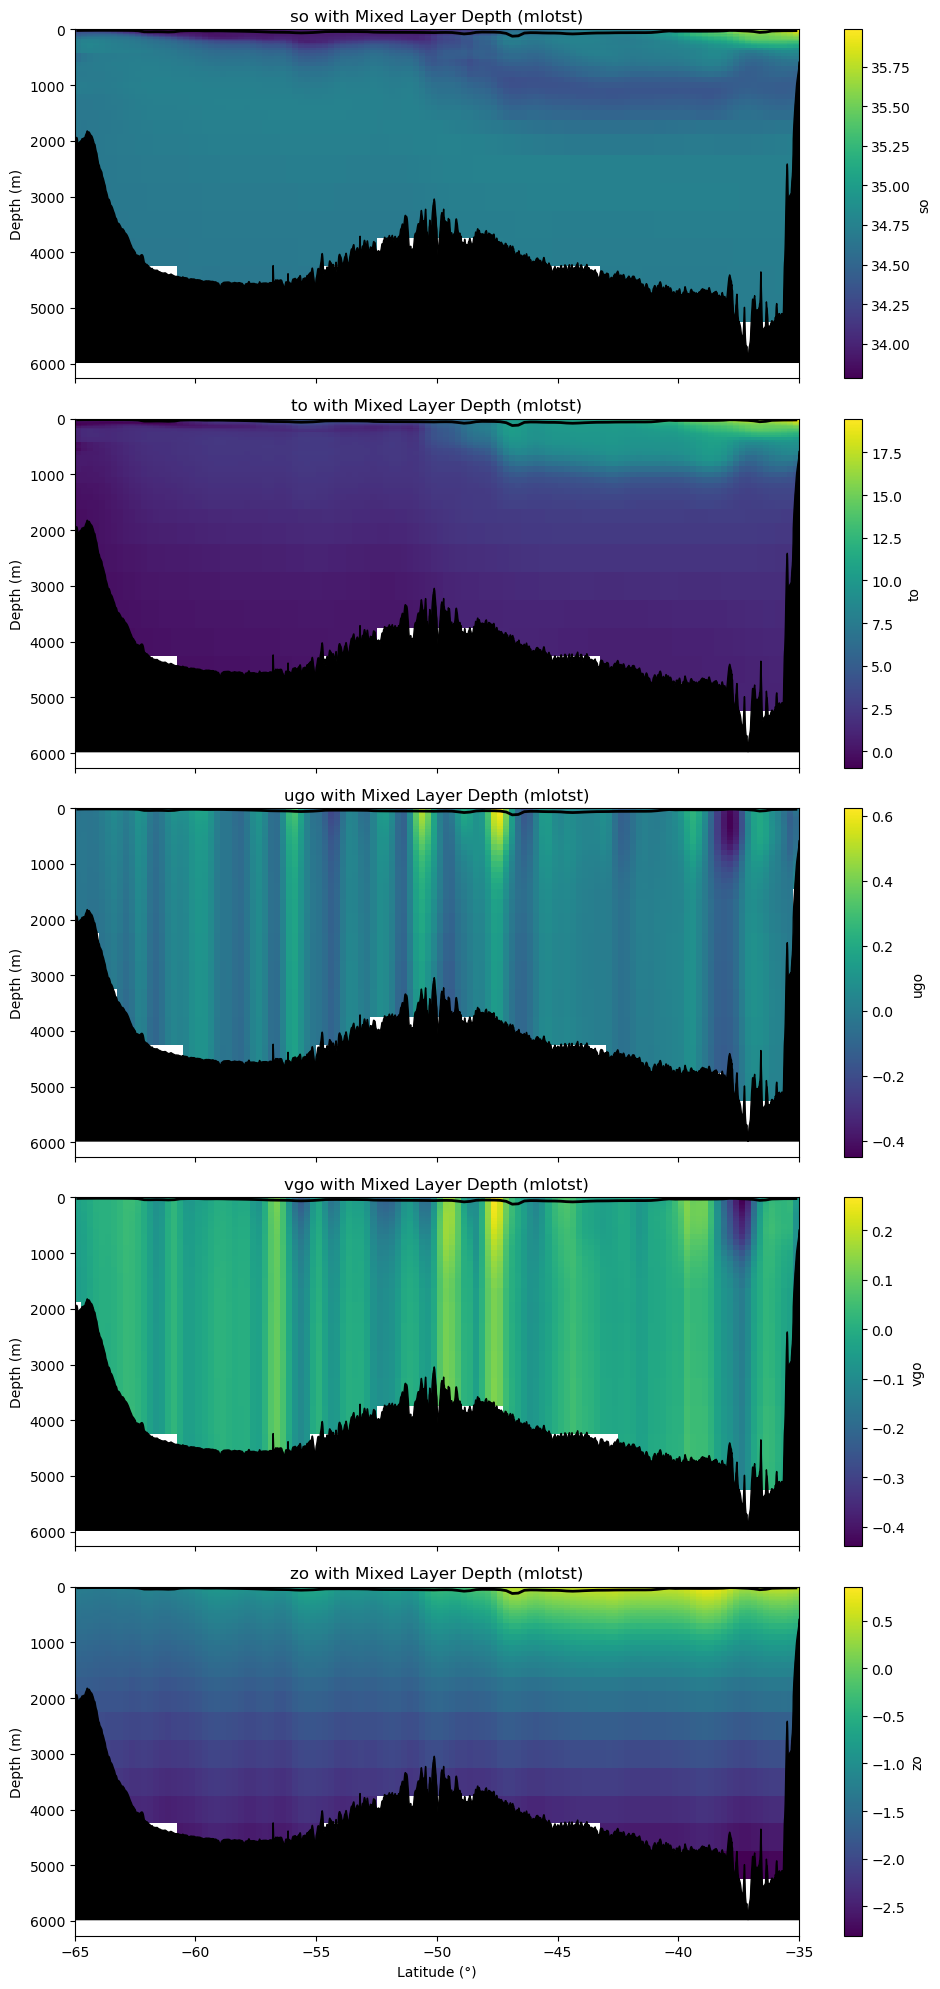

In [9]:
ds_subset = tsmld_nc_subset

variables = ["so", "to", "ugo", "vgo", "zo"]  # exclude mlotst

ds0 = ds_subset.isel(time=0)
ds0_line = ds0.sel(longitude=ds0.longitude, method="nearest").squeeze()

# Extract mixed layer depth (1D: latitude)
mld = ds0_line["mlotst"]                      # shape = (latitude,)
lat = ds0_line.latitude                       # 1D
depth = ds0_line.depth                        # 1D

# Broadcast MLD to 2D (depth × latitude) so contour can plot
# The contour will only show one curve, but broadcasting keeps API consistent
mld_2d = np.tile(mld.values, (depth.size, 1))

# Prepare figure
fig, axes = plt.subplots(len(variables), 1, figsize=(10, 20), sharex=True)

for ax, var in zip(axes, variables):

    da = ds0_line[var].transpose("depth", "latitude")

    # Pcolormesh of variable
    pcm = ax.pcolormesh(
        lat,
        depth,
        da,
        shading="auto"
    )

    # Add MLD contour (plotted as a horizontal line that follows latitude)
    ax.contour(
        lat,
        depth,
        mld_2d,
        levels=[0],        # dummy level, so only the line is plotted
        colors="black",
        linewidths=2
    )

    # Alternatively: directly plot the curve (cleaner)
    ax.plot(lat, mld, color="black", linewidth=2)

    ax.invert_yaxis()
    ax.set_ylabel("Depth (m)")
    ax.set_title(f"{var} with Mixed Layer Depth (mlotst)")
    
    ax.fill_between(ocean_depth_lat, ocean_depth, ocean_depth.max(),
                color='black', alpha=1)
    
    fig.colorbar(pcm, ax=ax, label=var)

axes[-1].set_xlabel("Latitude (°)")
plt.tight_layout()
plt.show()

## Generate GIFs of select variables over custom time period

Modify user options to select variables, time period and frame rate

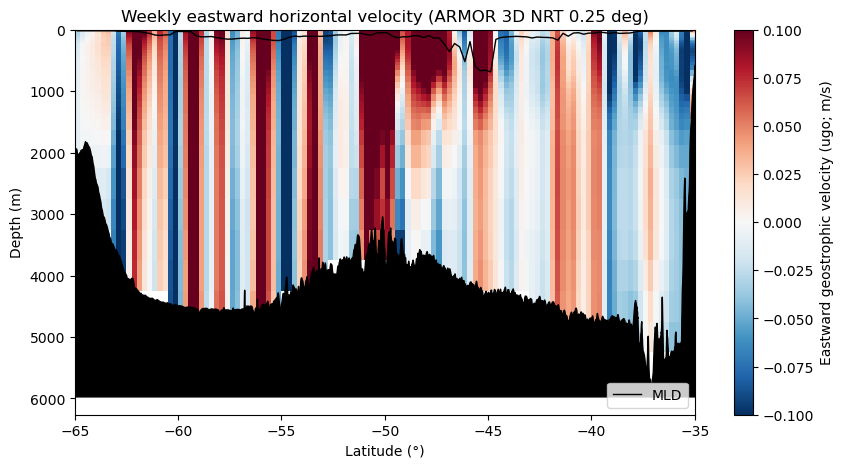

MovieWriter imagemagick unavailable; using Pillow instead.


Animation written and saved


In [10]:
ds_subset = tsmld_nc_subset

# ----------------------------
# USER OPTIONS
# ----------------------------

var = "ugo"                # variable to animate: so, to, vgo, ugo, zo
lon0 = ds_subset.longitude.values               # or manually: lon0 = 115
time_start = "2023-11-01"  # <-- choose start date
time_end   = "2024-03-31"  # <-- choose end date
fps = 8                    # animation speed

# ----------------------------
# TIME SUBSETTING
# ----------------------------

ds_sub = ds_subset.sel(time=slice(time_start, time_end))

# Extract first slice for setup
sample = ds_sub.isel(time=0)
transect = sample.sel(longitude=lon0, method="nearest").squeeze()

lat = transect.latitude
depth = transect.depth

# Mixed layer depth (constant for animation? or also animated?)
# If animated:
# mld = ds_sub["mlotst"].sel(longitude=lon0, method="nearest")
# If static (first timestep):
mld0 = sample["mlotst"].sel(longitude=lon0, method="nearest").values

# ----------------------------
# FIGURE SETUP
# ----------------------------

fig, ax = plt.subplots(figsize=(10, 5))

# First frame
da0 = transect[var].transpose("depth", "latitude")
#pcm = ax.pcolormesh(lat, depth, da0, shading="auto") # standard viridis colormap
abs_max = np.max(np.abs(da0.values))
pcm = ax.pcolormesh(
    lat,
    depth,
    da0,
    shading="auto",
    cmap="RdBu_r",
    vmin=-abs_max,
    vmax=abs_max
)

# MLD line
mld_line, = ax.plot(lat, mld0, color="black", linewidth=1, label = 'MLD')

# Time counter text
time_text = ax.text(
    0.4, 0.05, "",
    transform=ax.transAxes,
    color="white",
    fontsize=14,
    bbox=dict(facecolor="black", alpha=0.5, pad=3)
)

# Bathymetry mask
ax.fill_between(ocean_depth_lat, ocean_depth, ocean_depth.max(),
                color='black', alpha=1)

ax.legend(loc="lower right")

ax.invert_yaxis()
ax.set_xlabel("Latitude (°)")
ax.set_ylabel("Depth (m)")
ax.set_title("Weekly eastward horizontal velocity (ARMOR 3D NRT 0.25 deg)")
#cbar = fig.colorbar(pcm, ax=ax, label=var)
cbar = fig.colorbar(pcm, ax=ax, label="Eastward geostrophic velocity (ugo; m/s)")

# ----------------------------
# ANIMATION FUNCTION
# ----------------------------

def update(frame):
    ds_t = ds_sub.isel(time=frame)
    transect_t = ds_t.sel(longitude=lon0, method="nearest").squeeze()

    # update pcolormesh
    da = transect_t[var].transpose("depth", "latitude")
    pcm.set_array(da.values.ravel())

    # update MLD if desired
    mld_t = transect_t["mlotst"].values
    mld_line.set_ydata(mld_t)

    # update time label
    timestamp = np.datetime_as_string(ds_sub.time.values[frame], unit="D")
    time_text.set_text(f"Time: {timestamp}")

    return pcm, mld_line, time_text

# ----------------------------
# RUN ANIMATION
# ----------------------------

anim = FuncAnimation(
    fig, update,
    frames=ds_sub.time.size,
    interval=1000 / fps,
    blit=False
)

plt.show()

#plt.close(fig)  # prevents extra static output in notebooks
# Option B: save as GIF
anim.save("ugo_animation.gif", writer="imagemagick", fps=4)

print("Animation written and saved")

# SSH/SLA animation

https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/description

In [11]:
ssh_nc = xr.open_dataset('CMS ARMOR 3D TSMLD Product/CMEMS_SLA_glo_phy_SSH_allsat_90E_160E_65S_35S.nc')

## Plot single time frame of SLA (mapped) and meridional transect along 115E

In [ ]:
# SR3 transect datapoints: 
sr3_lats = np.array([-65,   -56.93,  -44])
sr3_lons = np.array([140,   140,      146.32])

# Build cumulative distance along polyline
d = np.zeros_like(sr3_lats)
for i in range(1, len(d)):
    d[i] = d[i-1] + np.hypot(
        sr3_lats[i] - sr3_lats[i-1],
        sr3_lons[i] - sr3_lons[i-1]
    )

# Make a finely sampled transect (e.g., 300 points)
N = 300
d_new = np.linspace(0, d[-1], N)

lat_f = interp1d(d, sr3_lats)
lon_f = interp1d(d, sr3_lons)

sr3_lat_dense = lat_f(d_new)
sr3_lon_dense = lon_f(d_new)

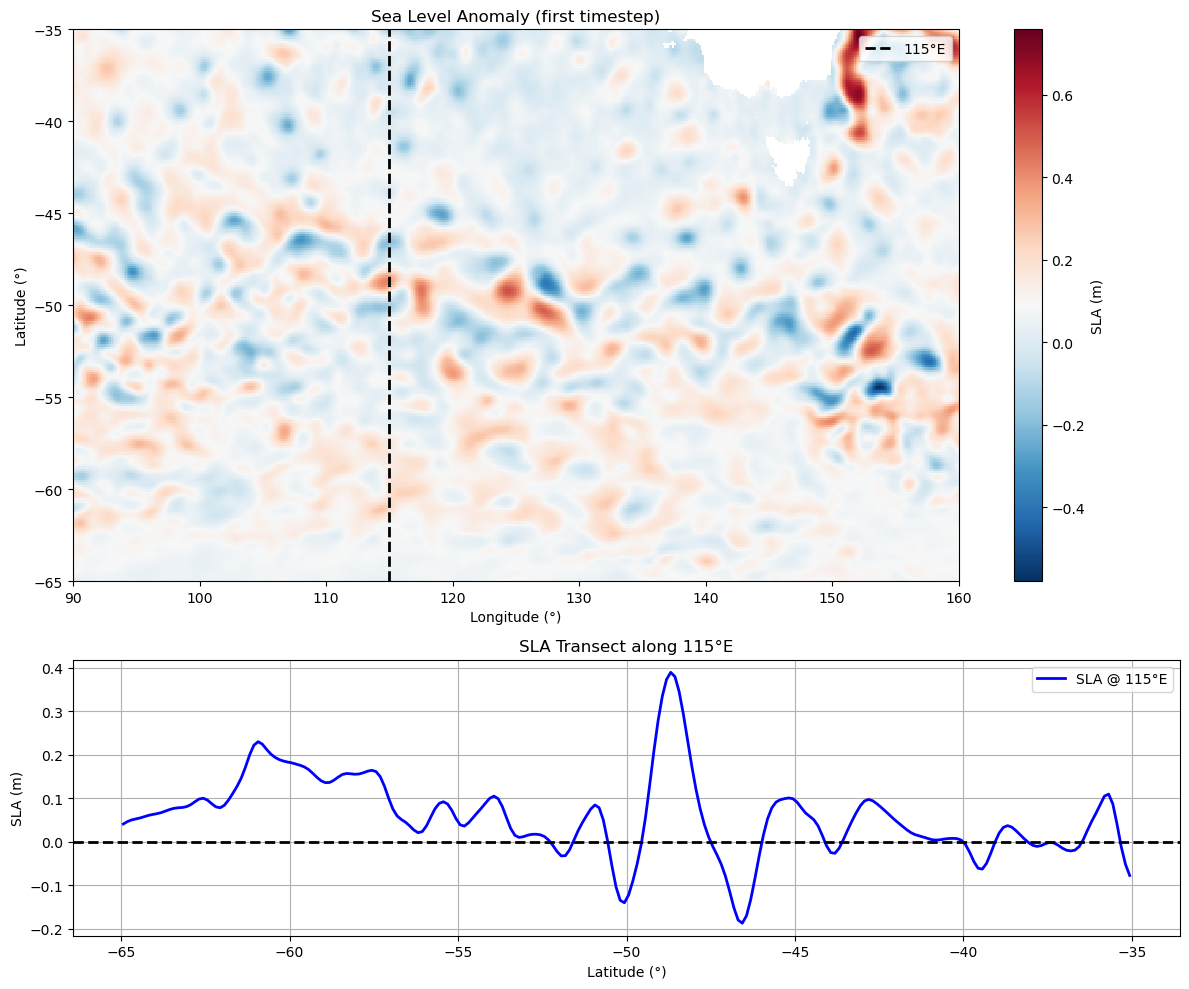

In [13]:
# Select first timestep
sla0 = ssh_nc['sla'].isel(time=0)  ## Can select custom date (daily steps) e.g. time = "2024-01-01"

# Coordinates
lat = sla0.latitude
lon = sla0.longitude

# ----------------------------
# Extract transect along 115°E
# ----------------------------
lon_line = 115
# Find nearest longitude index
sla_transect = sla0.sel(longitude=lon_line, method="nearest")

# ----------------------------
# Figure with two panels
# ----------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios':[2,1]})

# --- Top panel: map ---
pcm = axes[0].pcolormesh(
    lon,
    lat,
    sla0,
    shading='auto',
    cmap='RdBu_r'
)
axes[0].axvline(x=lon_line, color='black', linestyle='--', linewidth=2, label=f"{lon_line}°E")
axes[0].set_xlabel("Longitude (°)")
axes[0].set_ylabel("Latitude (°)")
axes[0].set_title("Sea Level Anomaly (first timestep)")
axes[0].legend(loc="upper right")
cbar = fig.colorbar(pcm, ax=axes[0], label="SLA (m)")

# --- Bottom panel: transect ---
axes[1].plot(lat, sla_transect, color='blue', linewidth=2, label=f"SLA @ {lon_line}°E")
axes[1].set_xlabel("Latitude (°)")
axes[1].axhline(y=0,color = 'black', linestyle = '--', linewidth = 2)
axes[1].set_ylabel("SLA (m)")
axes[1].set_title(f"SLA Transect along {lon_line}°E")
axes[1].legend(loc="upper right")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Animate! 

Choose a custom time period, longitude slice and frame rate. Saves a GIF but you can also save as an MP4 for play/pause functionality. 

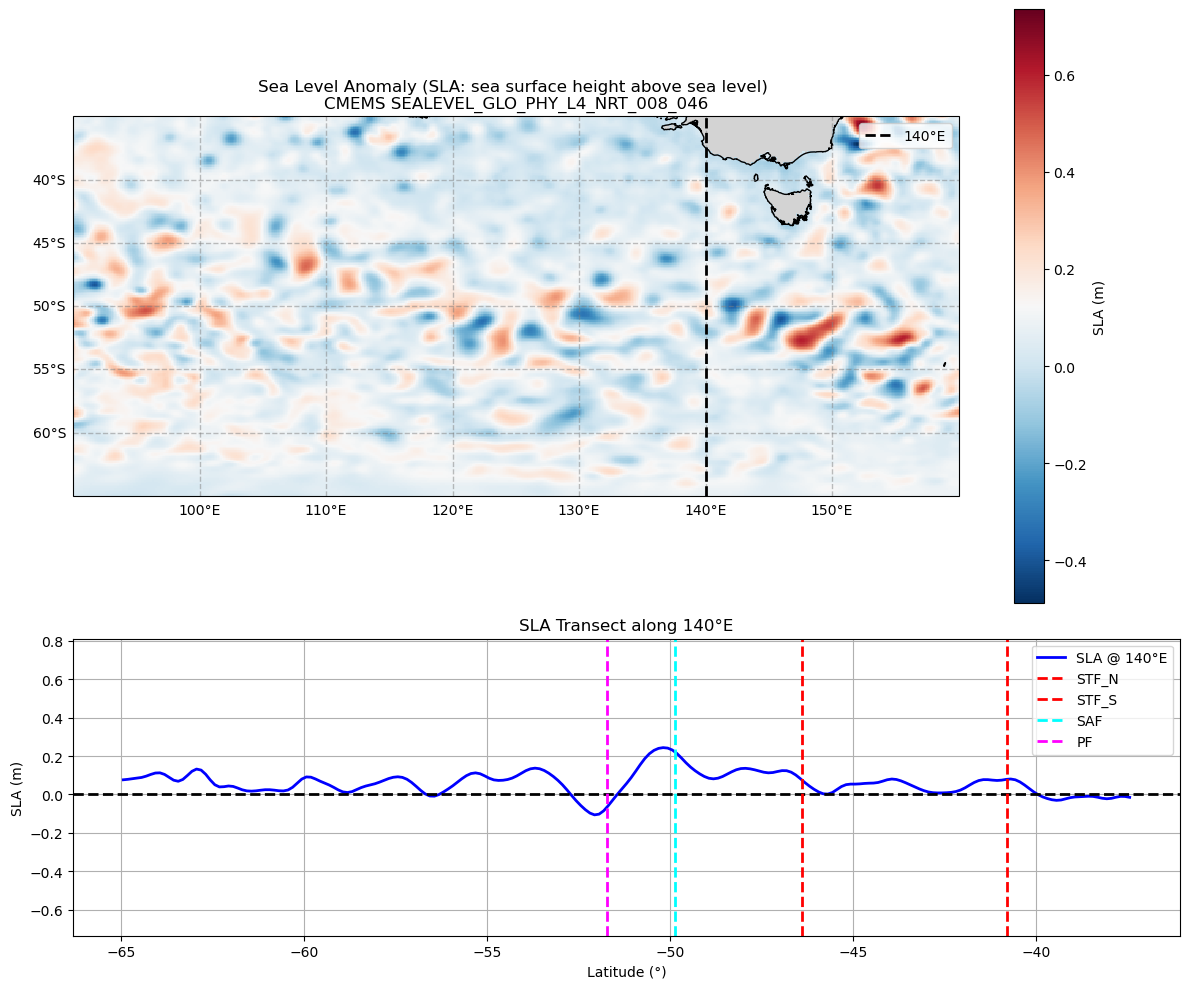

MovieWriter imagemagick unavailable; using Pillow instead.


Animation saved!


In [15]:
# ----------------------------
# USER OPTIONS
# ----------------------------
var = "sla"
lon_line = 140                 # transect longitude
time_start = "2017-12-01"              # e.g., "2023-11-01" or None for full dataset
time_end   = "2018-02-28"              # e.g., "2024-03-31" or None
fps = 16                        # animation speed

# ----------------------------
# TIME SUBSETTING
# ----------------------------
if time_start and time_end:
    ds_sub = ssh_nc.sel(time=slice(time_start, time_end))
else:
    ds_sub = ssh_nc.copy()

lat = ds_sub.latitude
lon = ds_sub.longitude

# ----------------------------
# FIGURE SETUP WITH CARTOPY
# ----------------------------
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 1, height_ratios=[2,1])

# --- Top panel: SLA map with coastlines ---
ax_map = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
sample = ds_sub.isel(time=0)

pcm = ax_map.pcolormesh(
    lon, lat, sample[var],
    shading='auto',
    cmap='RdBu_r',
    transform=ccrs.PlateCarree()
)

# Coastlines
ax_map.coastlines(resolution='10m', color='black', linewidth=1)
ax_map.add_feature(cfeature.LAND, facecolor='lightgray')
ax_map.add_feature(cfeature.BORDERS, linestyle=':')

# Add gridlines
gl = ax_map.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}


# Vertical line for transect
vline = ax_map.axvline(lon_line, color='black', linestyle='--', linewidth=2, label=f"{lon_line}°E")

ax_map.set_title("Sea Level Anomaly (SLA: sea surface height above sea level) \nCMEMS SEALEVEL_GLO_PHY_L4_NRT_008_046")
ax_map.set_xlabel("Longitude (°)")
ax_map.set_ylabel("Latitude (°)")
cbar = fig.colorbar(pcm, ax=ax_map, orientation='vertical', label="SLA (m)")
ax_map.legend(loc="upper right")

# --- Bottom panel: SLA transect ---

ax_transect = fig.add_subplot(gs[1, 0])
transect0 = sample[var].sel(longitude=lon_line, method="nearest")
line, = ax_transect.plot(lat, transect0, color='blue', linewidth=2, label=f"SLA @ {lon_line}°E")
ax_transect.set_xlabel("Latitude (°)")
ax_transect.set_ylabel("SLA (m)")

ax_transect.axhline(y=0,color = 'black', linestyle = '--', linewidth = 2)
ax_transect.axvline(x=-40.8,color = 'red', linestyle = '--', linewidth = 2, label = "STF_N")
ax_transect.axvline(x=-46.39,color = 'red', linestyle = '--', linewidth = 2, label = "STF_S")
ax_transect.axvline(x=-49.87,color = 'cyan', linestyle = '--', linewidth = 2, label = "SAF")
ax_transect.axvline(x=-51.71,color = 'magenta', linestyle = '--', linewidth = 2, label = "PF")

ax_transect.set_title(f"SLA Transect along {lon_line}°E")
ax_transect.grid(True)
ax_transect.legend(loc="upper right")
ax_transect.set_ylim(ds_sub[var].min(), ds_sub[var].max())

# Time counter
time_text = ax_map.text(
    0.7, 0.05, "",
    transform=ax_map.transAxes,
    color="black",
    fontsize=14,
    bbox=dict(facecolor="white", alpha=0.5, pad=3)
)

plt.tight_layout()

# ----------------------------
# ANIMATION FUNCTION
# ----------------------------
def update(frame):
    ds_t = ds_sub.isel(time=frame)
    
    # Update map
    pcm.set_array(ds_t[var].values.ravel())
    
    # Update transect
    transect_t = ds_t[var].sel(longitude=lon_line, method="nearest")
    line.set_ydata(transect_t.values)
    
    # Update time label
    timestamp = np.datetime_as_string(ds_sub.time.values[frame], unit="D")
    time_text.set_text(f"Time: {timestamp}")
    
    return pcm, line, time_text

# ----------------------------
# RUN ANIMATION
# ----------------------------
anim = FuncAnimation(
    fig, update,
    frames=ds_sub.time.size,
    interval=1000 / fps,
    blit=False
)

plt.show()

# Option A: Save GIF
anim.save("sla_map_transect_animation.gif", writer="imagemagick", fps=fps)

# Option B: save as MP4
# anim.save("SLA_animation.mp4", writer="ffmpeg", fps=4)

print("Animation saved!")

## Include both SR3 and I09S transect lines. 

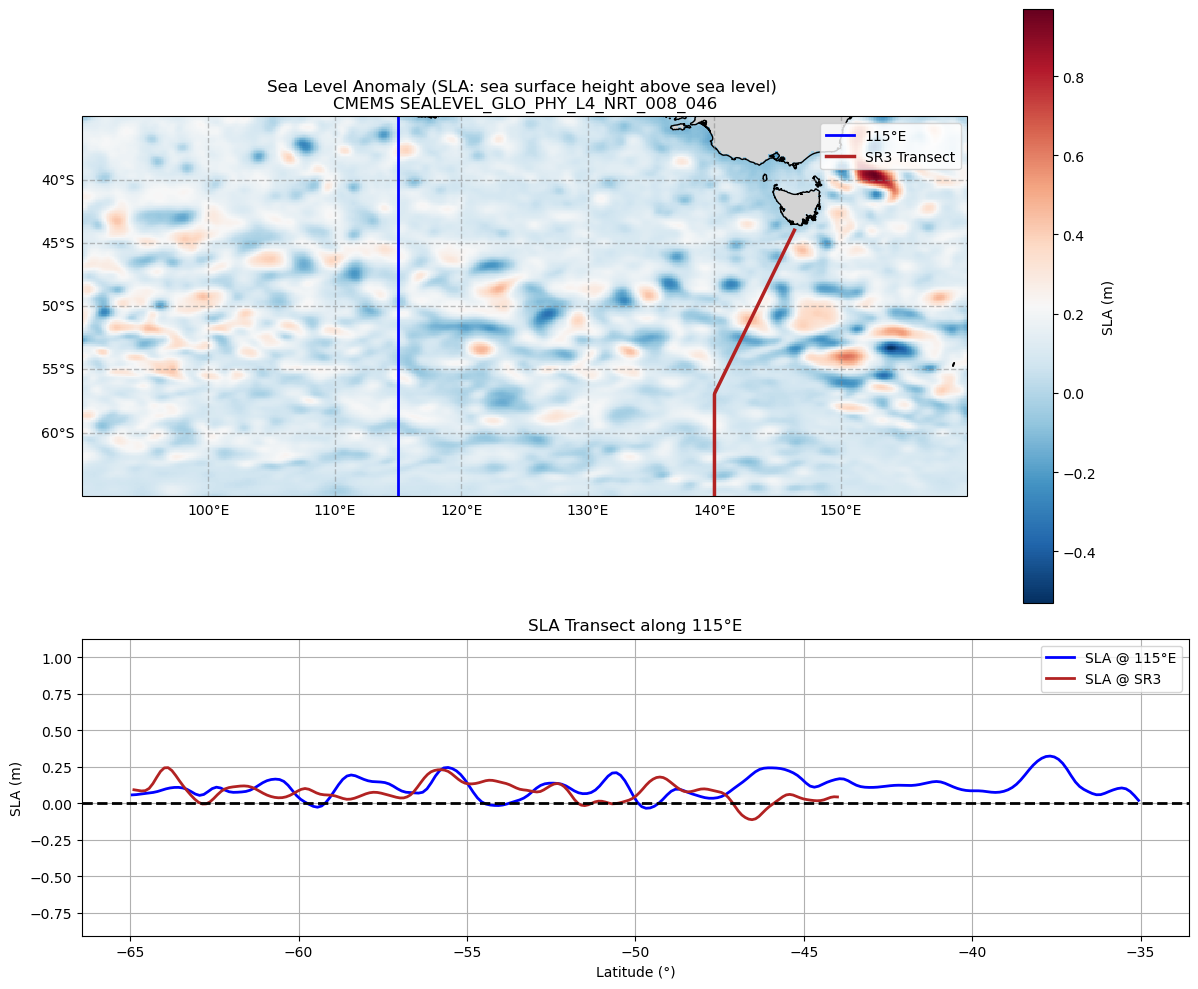

MovieWriter imagemagick unavailable; using Pillow instead.


Animation saved!


In [27]:
# ---------------------------------
# SR3 TRANSECT SETUP: Use a polyline to resample the SLA points using a bilinear interpolation method. 
# ---------------------------------

# Anchor points of SR3 section. Users can define any vector for a transect here and apply a bilinear interpolation to extract SLA values from their selected transect. Just remember to update instances of 'sr3_lats' and 'sr3_lons'.
sr3_lats = np.array([-65, -56.93, -44])
sr3_lons = np.array([140, 140, 146.32])

# Build cumulative distance for interpolation
d = np.zeros_like(sr3_lats)
for i in range(1, len(d)):
    d[i] = d[i-1] + np.hypot(
        sr3_lats[i] - sr3_lats[i-1],
        sr3_lons[i] - sr3_lons[i-1]
    )

# Create a dense sampling of SR3 transect (200 points)
N = 200
d_new = np.linspace(0, d[-1], N)

lat_f = interp1d(d, sr3_lats)
lon_f = interp1d(d, sr3_lons)

sr3_lat_dense = lat_f(d_new)
sr3_lon_dense = lon_f(d_new)

# --- NEW: BILINEAR INTERPOLATION ---
# Build interpolator for timestep 0 (example)
sla = ssh_nc[var]   # this must be 3D: (time, lat, lon)

lats = sla.latitude.values
lons = sla.longitude.values

sla0_interp = RegularGridInterpolator(
    (lats, lons),
    sla.isel(time=0).values,
    bounds_error=False,
    fill_value=np.nan
)

# Evaluate SLA along SR3
sr3_points = np.column_stack((sr3_lat_dense, sr3_lon_dense))
sr3_transect0 = sla0_interp(sr3_points)

# ----------------------------
# USER OPTIONS
# ----------------------------
var = "sla"
lon_line = 115                 # transect longitude
time_start = "2023-12-15"              # e.g., "2023-11-01" or None for full dataset
time_end   = "2024-03-15"              # e.g., "2024-03-31" or None
fps = 16                        # animation speed

# ----------------------------
# TIME SUBSETTING
# ----------------------------
if time_start and time_end:
    ds_sub = ssh_nc.sel(time=slice(time_start, time_end))
else:
    ds_sub = ssh_nc.copy()

lat = ds_sub.latitude
lon = ds_sub.longitude

# ----------------------------
# FIGURE SETUP WITH CARTOPY
# ----------------------------
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 1, height_ratios=[2,1])

# --- Top panel: SLA map with coastlines ---
ax_map = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
sample = ds_sub.isel(time=0)

pcm = ax_map.pcolormesh(
    lon, lat, sample[var],
    shading='auto',
    cmap='RdBu_r',
    transform=ccrs.PlateCarree()
)

# Coastlines
ax_map.coastlines(resolution='10m', color='black', linewidth=1)
ax_map.add_feature(cfeature.LAND, facecolor='lightgray')
ax_map.add_feature(cfeature.BORDERS, linestyle=':')

# Add gridlines
gl = ax_map.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}


# Vertical line for transect
vline = ax_map.axvline(lon_line, color='blue', linestyle='-', linewidth=2, label=f"{lon_line}°E")

# SR3 line on the map
sr3_line_map, = ax_map.plot(
    sr3_lon_dense, sr3_lat_dense,
    color='firebrick',
    linewidth=2.5,
    label='SR3 Transect',
    transform=ccrs.PlateCarree()
)

ax_map.set_title("Sea Level Anomaly (SLA: sea surface height above sea level) \nCMEMS SEALEVEL_GLO_PHY_L4_NRT_008_046")
ax_map.set_xlabel("Longitude (°)")
ax_map.set_ylabel("Latitude (°)")
cbar = fig.colorbar(pcm, ax=ax_map, orientation='vertical', label="SLA (m)")
ax_map.legend(loc="upper right")

# --- Bottom panel: SLA transect ---

ax_transect = fig.add_subplot(gs[1, 0])
transect0 = sample[var].sel(longitude=lon_line, method="nearest")
line, = ax_transect.plot(lat, transect0, color='blue', linewidth=2, label=f"SLA @ {lon_line}°E")

# SR3 transect SLA line (initial timestep)
sr3_line_plot, = ax_transect.plot(
    sr3_lat_dense,
    sr3_transect0,
    color='firebrick',
    linewidth=2,
    label='SLA @ SR3'
)

ax_transect.set_xlabel("Latitude (°)")
ax_transect.set_ylabel("SLA (m)")

ax_transect.axhline(y=0,color = 'black', linestyle = '--', linewidth = 2)
#ax_transect.axvline(x=-40.8,color = 'red', linestyle = '--', linewidth = 2, label = "STF_N")
#ax_transect.axvline(x=-46.39,color = 'red', linestyle = '--', linewidth = 2, label = "STF_S")
#ax_transect.axvline(x=-49.87,color = 'cyan', linestyle = '--', linewidth = 2, label = "SAF")
#ax_transect.axvline(x=-51.71,color = 'magenta', linestyle = '--', linewidth = 2, label = "PF")

ax_transect.set_title(f"SLA Transect along {lon_line}°E")
ax_transect.grid(True)
ax_transect.legend(loc="upper right")
ax_transect.set_ylim(ds_sub[var].min(), ds_sub[var].max())

# Time counter
time_text = ax_map.text(
    0.4, 0.05, "",
    transform=ax_map.transAxes,
    color="black",
    fontsize=14,
    bbox=dict(facecolor="white", alpha=0.5, pad=3)
)

plt.tight_layout()

# ----------------------------
# ANIMATION FUNCTION
# ----------------------------
def update(frame):
    ds_t = ds_sub.isel(time=frame)
    
    # Update map
    pcm.set_array(ds_t[var].values.ravel())
    
    # Update fixed 115 transect
    transect_t = ds_t[var].sel(longitude=lon_line, method="nearest")
    line.set_ydata(transect_t.values)
    
    # Update SR3 transect line
    sla_interp = RegularGridInterpolator(
        (ds_t.latitude.values, ds_t.longitude.values),
        ds_t[var].values,
        bounds_error=False,
        fill_value=np.nan
    )
    
    sr3_sla_t = sla_interp(np.column_stack((sr3_lat_dense, sr3_lon_dense)))
    sr3_line_plot.set_ydata(sr3_sla_t)
    
    # Update time label
    timestamp = np.datetime_as_string(ds_sub.time.values[frame], unit="D")
    time_text.set_text(f"Time: {timestamp}")
    
    return pcm, line, sr3_line_plot, time_text

# ----------------------------
# RUN ANIMATION
# ----------------------------
anim = FuncAnimation(
    fig, update,
    frames=ds_sub.time.size,
    interval=1000 / fps,
    blit=False
)

plt.show()

# Option A: Save GIF
anim.save("sla_map_transect_animation_sr3_i9.gif", writer="imagemagick", fps=fps)

# Option B: save as MP4
# anim.save("SLA_animation.mp4", writer="ffmpeg", fps=4)

print("Animation saved!")